# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
from matplotlib.patches import Rectangle

%matplotlib inline

In [2]:
dataset = get_dataset("./data/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['./data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_images(batch):
    
    image = batch['image'].numpy()
    filename = batch['filename']
    bboxes = batch['groundtruth_boxes'].numpy()
    classes = batch['groundtruth_classes'].numpy()
    w,h,c = image.shape
    bboxes[:,(0,2)] *= h
    bboxes[:,(1,3)] *= w
    
    f, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image.astype(np.uint8))
    
    colormap = {1: 'red', 2: 'b', 4: 'g'}
    for cl, bb in zip(classes, bboxes):
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2- x1, y2-y1, facecolor='none', edgecolor=colormap[cl])
        ax.add_patch(rec)
    plt.title(f'Image: {filename}')
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

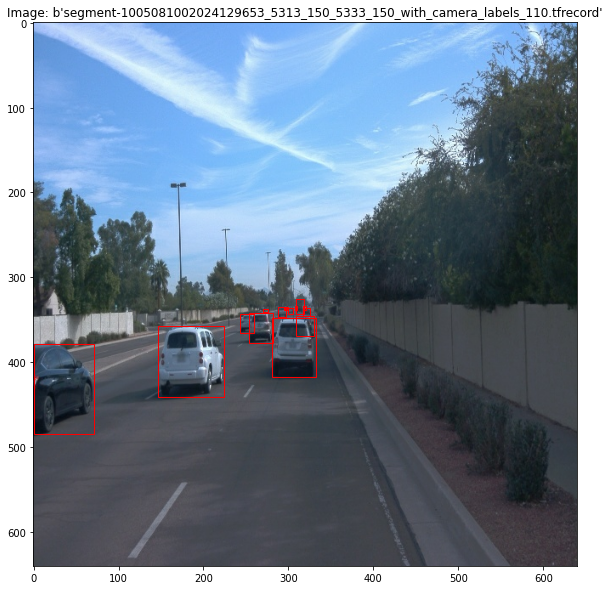

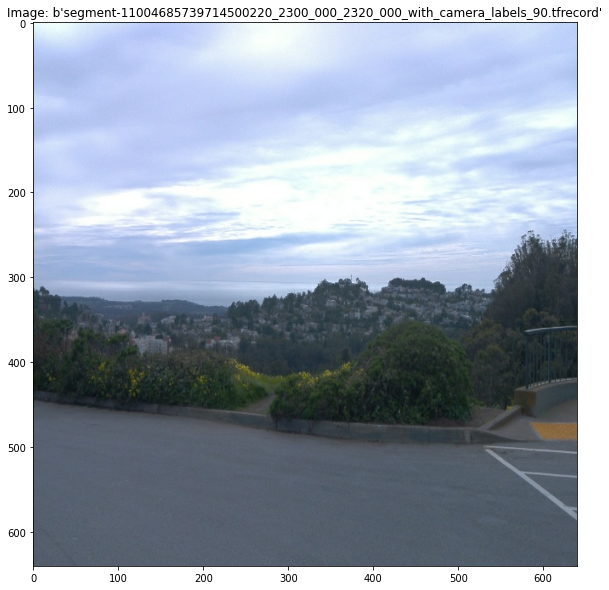

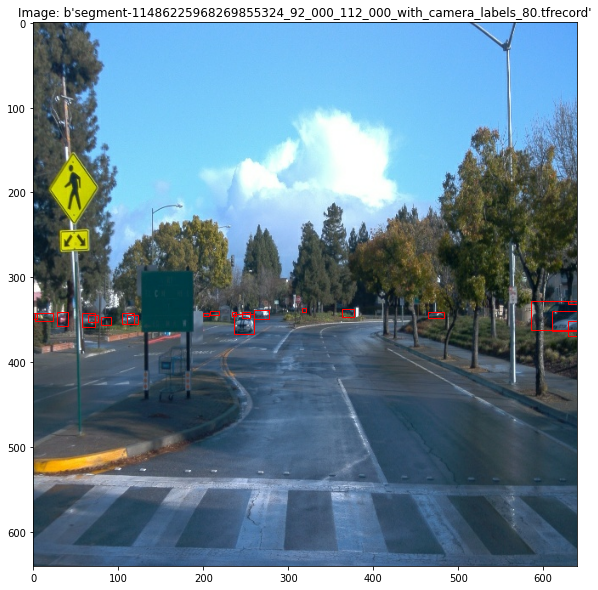

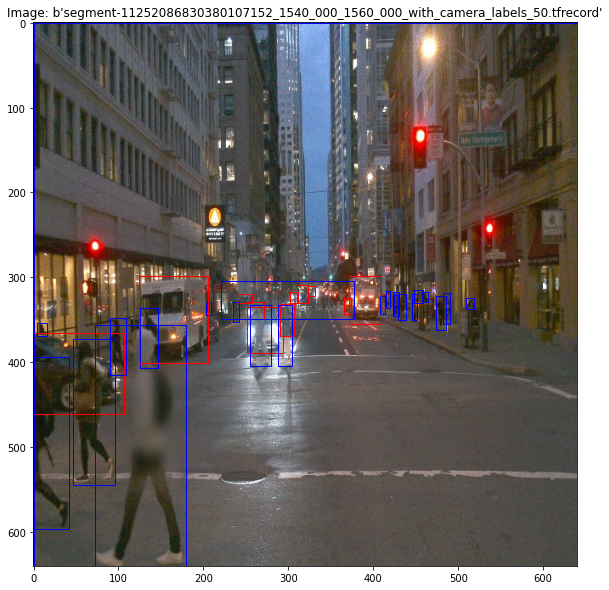

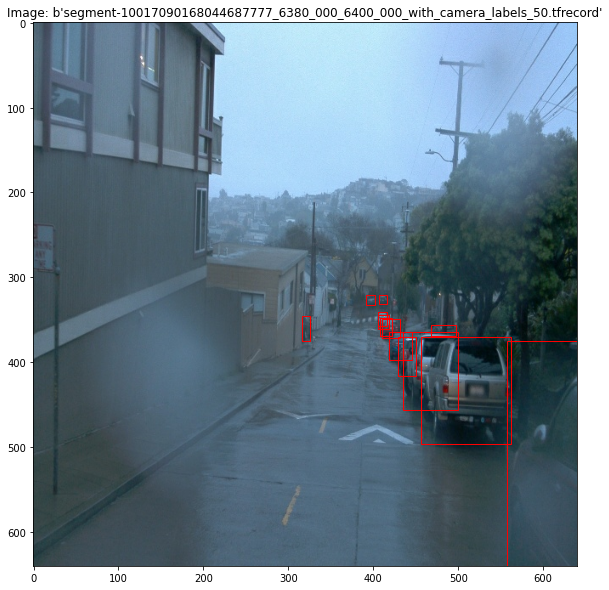

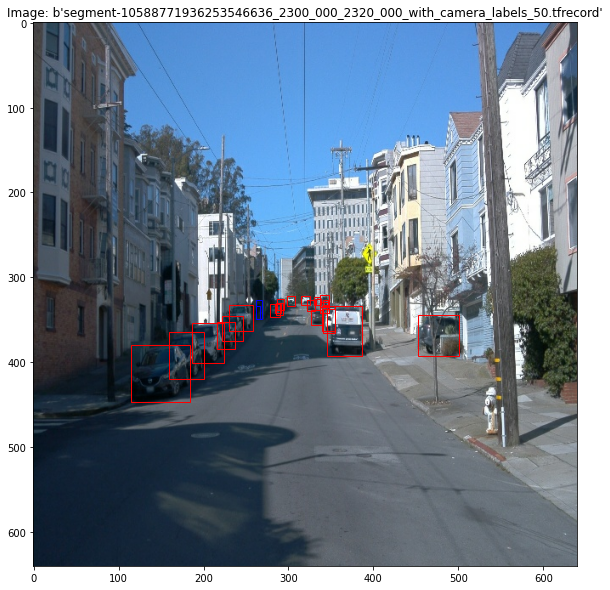

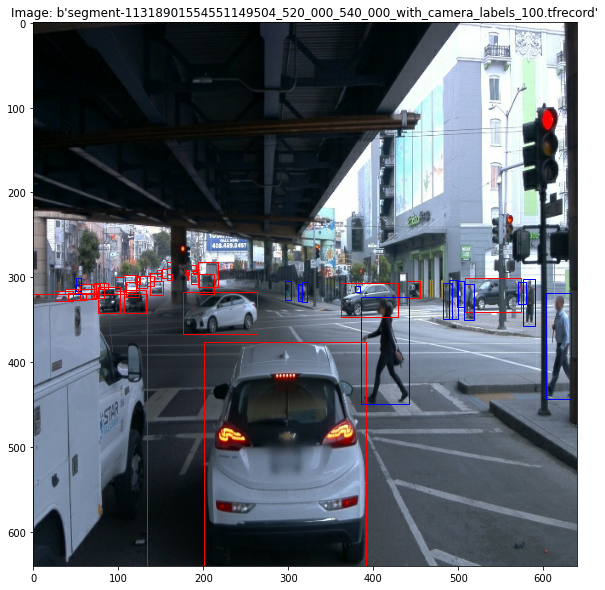

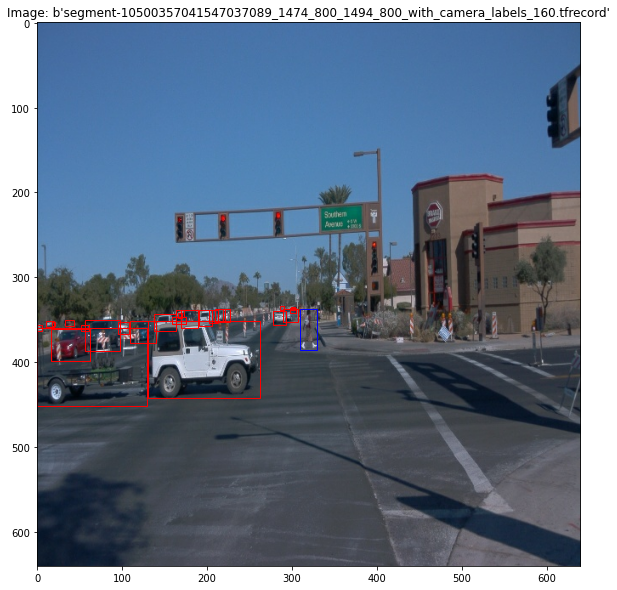

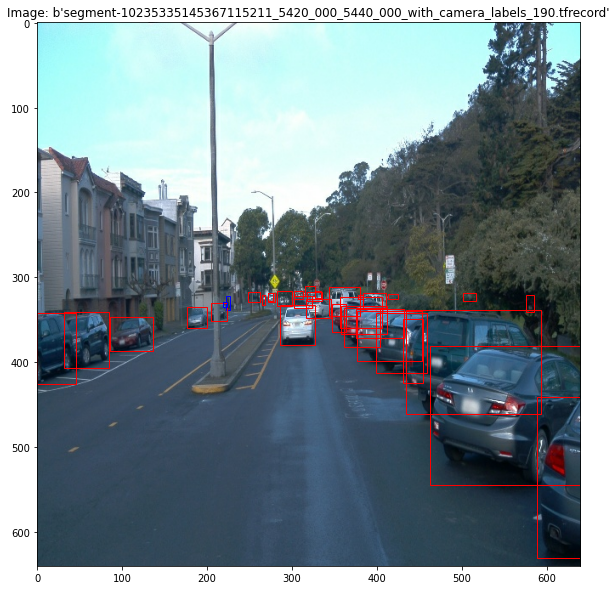

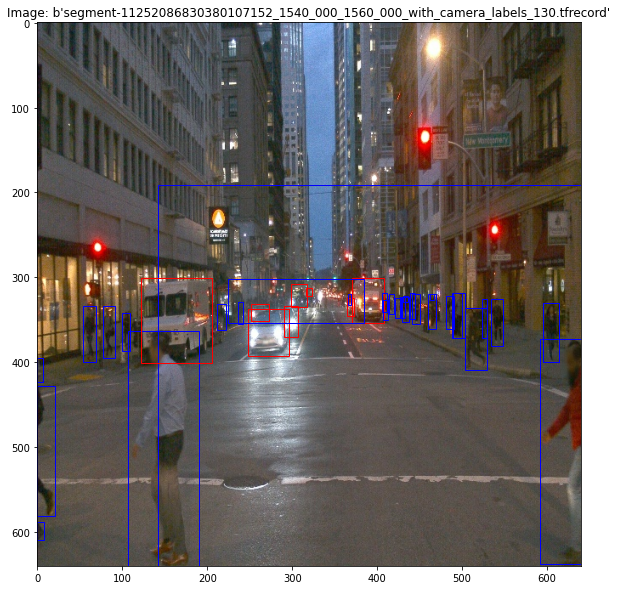

In [4]:
# Display 10 random images in dataset
buffer_size = 86
dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True)
dataset = dataset.take(10)
for batch in dataset:
    
    display_images(batch)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

### Function to analyze the data set

In [260]:
import glob
import sys
import os
import numpy
import matplotlib.pyplot as plt

def statistics(dataset):
    obj_classes = {"vehicle": 0, "pedestrian": 0, "cyclist": 0}
    obj_numbers = []
    classes_ids = {"vehicle": 1, "pedestrian": 2, "cyclist": 4}
    
    bb_data = {"areas": []}
    bb_areas = []
    for idx, data in enumerate(dataset):
        if idx >= 20000:
            break
        
        # statistics about object classes        
        gt_labels = data['groundtruth_classes'].numpy()
        obj_numbers.append(len(gt_labels))
        for label in gt_labels:
            if label == classes_ids["vehicle"]:
                obj_classes["vehicle"] += 1
            if label == classes_ids["pedestrian"]:
                obj_classes["pedestrian"] += 1
            if label == classes_ids["cyclist"]:
                obj_classes["cyclist"] += 1
        
        # statistics about bbox
        img  = data['image'].numpy()
        h, w, _c = img.shape
        bboxes = data['groundtruth_boxes'].numpy()
        bboxes[:,(0,2)] *= h
        bboxes[:,(1,3)] *= w
        h_bbox = bboxes[:,2] - bboxes[:,0]
        w_bbox = bboxes[:,3] - bboxes[:,1]
            
        area = w_bbox * h_bbox
        bb_areas.extend(area)
        
    bb_data["areas"] = bb_areas
    
    return obj_classes, obj_numbers, bb_data

# prepare_statistics_for_plot
def return_statistics(dataset):
    class_stat = statistics(dataset)
    # Number of objects
    number_objects_stat = {}
    max_obj_class = max(class_stat[1])
    min_obj_class = min(class_stat[1])
    count_max_obj_class = class_stat[1].count(max_obj_class)
    count_min_obj_class = class_stat[1].count(min_obj_class)

    step = 10
    for start_interval in range(min_obj_class, max_obj_class, step):
        end_interval = start_interval + step
        interval = "{0}-{1}".format(start_interval, (end_interval - 1))
        value = len([x for x in class_stat[1] if x >= start_interval and x < end_interval])
        number_objects_stat.update({interval: value})

    # bounding box 
    bb_data_area = class_stat[2]["areas"]
    min_bb_area = min(bb_data_area)
    max_bb_area = max(bb_data_area)
    count_min_bb_area = bb_data_area.count(min_bb_area)
    count_max_bb_area = bb_data_area.count(max_bb_area)
    smallest_area = 0
    small_area = 0 
    medium_area = 0
    large_area = 0

    for area in bb_data_area:
        if area < 25.0:
            smallest_area += 1
        elif area >= 25.0 and area < 225.0:
            small_area += 1
        elif area >= 225.0 and area < 10000.0:
            medium_area += 1
        else:
            large_area += 1
    bb_stat = {"smallest": smallest_area, "small": small_area, "medium": medium_area, "large": large_area}
    return {"bb_data": {"areas_stat": bb_stat, "min_area": min_bb_area, "min_area_num": count_min_bb_area,
                        "max_area": max_bb_area, "max_area_num": count_max_bb_area},
            "object_classes": class_stat[0],
            "object_numbers" : {"obj_stat": number_objects_stat, "max_obj": max_obj_class, "max_obj_num": count_max_obj_class,
                               "min_obj": min_obj_class, "min_obj_num": count_min_obj_class}
           }

# plot statistics
def plot_statistics(data):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))

    # Object class distribution
    classes_data = data["object_classes"]
    axs[0].grid(zorder=0)
    axs[0].set_axisbelow(True) 
    axs[0].set_title("Object class distribution", fontsize=14)
    bars = axs[0].bar(classes_data.keys(), classes_data.values())
    axs[0].bar_label(bars)

    # Number of objects per an image
    num_obj_data = data["object_numbers"]
    min_obj_stat = num_obj_data["obj_stat"]
    axs[1].grid(zorder=0)
    axs[1].set_axisbelow(True) 
    axs[1].set_title("Number of objects per an image", fontsize=14)
    num_obj_bars = axs[1].bar(min_obj_stat.keys(), min_obj_stat.values())
    axs[1].bar_label(num_obj_bars)
    axs[1].text(5, 4250, "min = {0}, number of images = {1}\nmax={2}, number of images = {3}"
                        .format(num_obj_data["min_obj"], num_obj_data["min_obj_num"],
                                num_obj_data["max_obj"], num_obj_data["max_obj_num"]), fontsize=11)

    # Bounding box areas
    bb_data = data["bb_data"]
    bb_area_stat = bb_data["areas_stat"]
    axs[2].grid(zorder=0)
    axs[2].set_axisbelow(True) 
    axs[2].set_title("Bounding box areas", fontsize=14)
    bb_bars = axs[2].bar(bb_area_stat.keys(), bb_area_stat.values())
    axs[2].bar_label(bb_bars)
    axs[2].text(2.5, 200000, "min = {0:.3f}, number = {1}\nmax={2:.3f}, number = {3}"
                        .format(bb_data["min_area"], bb_data["min_area_num"],
                                bb_data["max_area"], bb_data["max_area_num"]), fontsize=11)

    plt.show()

### get_dataset function from utils with adaptation to use for analyzes

In [115]:
import tensorflow.compat as tf
from object_detection.protos import input_reader_pb2
from object_detection.builders.dataset_builder import build as build_dataset

def get_dataset(tfrecord_path, label_map='./label_map.pbtxt'):
    """
    Opens a tf record file and create tf dataset
    args:
      - tfrecord_path [str]: path to a tf record file
      - label_map [str]: path the label_map file
    returns:
      - dataset [tf.Dataset]: tensorflow dataset
    """
    input_config = input_reader_pb2.InputReader()
    input_config.label_map_path = label_map
    input_config.tf_record_input_reader.input_path[:] = tfrecord_path
    
    dataset = build_dataset(input_config)
    return dataset

### Data set analyze 

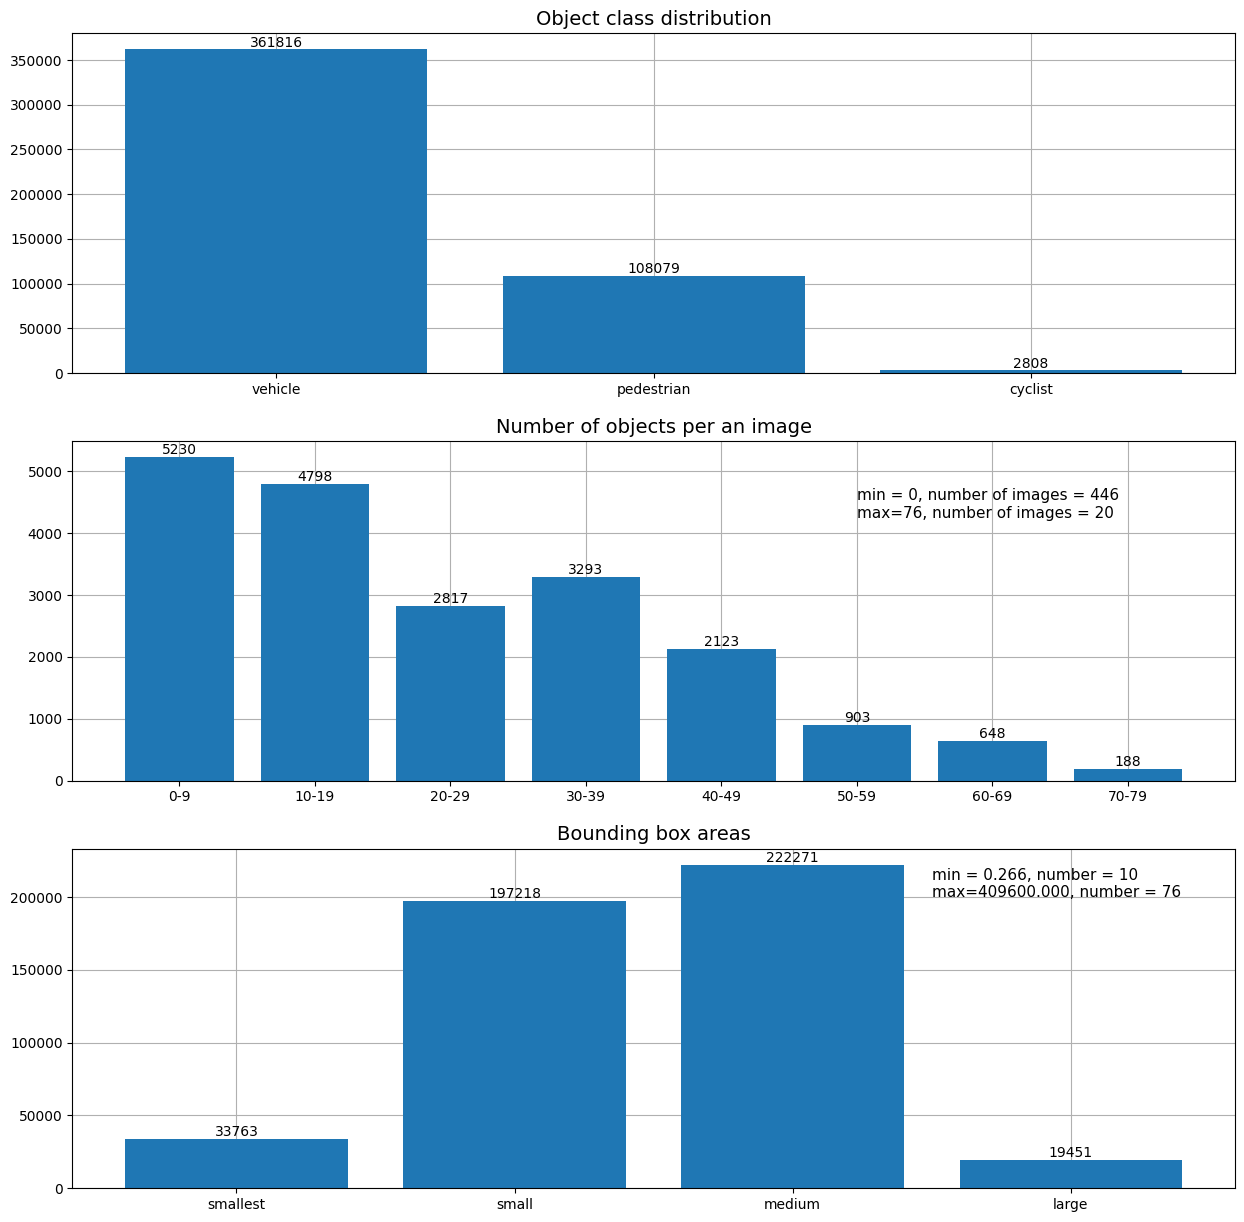

In [261]:
dataset = get_dataset(glob.glob("data/*/*.tfrecord"))
data = return_statistics(dataset)
plot_statistics(data)